## 1. Load packages

In [2]:
# data processing packages
import numpy as np
from numpy import random
import pandas as pd
import re

# machine learning packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

# visualization packages
import seaborn as sb
import matplotlib.pyplot as plt

# other packages
import torch
from pathlib import Path
import random

## 2. Read the files

In [3]:
## Create the necessary folders
Path('./Figures/').mkdir(parents=True, exist_ok=True)
Path('./Results/').mkdir(parents=True, exist_ok=True)

In [4]:
## Set path to the data set
dataset_path = "./dataset/77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "./dataset/clinical_data_breast_cancer.csv"
pam50_proteins = "./dataset/PAM50_proteins.csv"

## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical_file = pd.read_csv(clinical_info,header=0,index_col=0) ## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

# RefSeq protein ID (each protein has a unique ID in a RefSeq database)
print(data.index.name)
data.head()

RefSeq_accession_number


,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


## 3. Data Set Processing

In [5]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

data.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [6]:
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
print(data.shape)
datat = data.transpose()
print(datat.shape)

datat.head()

(12553, 83)
(83, 12553)


RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [7]:
print("Number of patients in clinical data set: ", len(clinical_file.index))
print("Number of patients in protein data set: ", len(datat.index))

Number of patients in clinical data set:  105
Number of patients in protein data set:  83


In [8]:
## Drop clinical entries for samples not in our protein data set
clinical = clinical_file.loc[[x for x in clinical_file.index.tolist() if x in datat.index],:]

print("The shape of the clinical data set: ", clinical.shape)
clinical.head()

The shape of the clinical data set:  (77, 29)


,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [9]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = datat.merge(clinical,left_index=True,right_index=True)

# Drop the duplicated columns (added by Pietro Gavazzi)
liste = merged.index.copy()
liste = list(liste)

for i in np.unique(merged.index):
    liste.remove(i)

## Change name to make it look nicer in the code!
processed = merged.drop(np.unique(liste))

print("Shape of the merged data set: ", processed.shape)
print("with %d patients and %d features" % (processed.shape[0], processed.shape[1]))

processed.head()

Shape of the merged data set:  (74, 12582)
with 74 patients and 12582 features


,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4


In [10]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
X = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_|YP_",x)) == True]]
Y = pd.get_dummies(processed.drop(X.columns, axis=1)['Integrated Clusters (with PAM50)'], prefix="PAM50")

## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
# processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
# processed_numerical_p50.head()

X.columns

Index(['NP_958782', 'NP_958785', 'NP_958786', 'NP_000436', 'NP_958781',
       'NP_958780', 'NP_958783', 'NP_958784', 'NP_112598', 'NP_001611',
       ...
       'NP_001193600', 'NP_061134', 'NP_932347', 'NP_003593', 'NP_997203',
       'NP_001191293', 'NP_775791', 'NP_004065', 'NP_068752', 'NP_219494'],
      dtype='object', length=12553)

In [11]:
Y.head()

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0


In [12]:
# Save the data
torch.save(X, './Results/X')
torch.save(Y, './Results/Y')

## 3. Data Engineering

In [13]:
# Read the processed data set
X = torch.load('./Results/X')
Y = torch.load('./Results/Y')

In [14]:
X.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.106650,NaN,-6.941181
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.801685,NaN,NaN,3.802310,-6.373934,-1.123160,NaN,NaN,NaN,NaN
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,NaN,NaN


In [15]:
Y.head()

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0


### 3.1 Missing value process
We drop all the columns with nan values

In [16]:
nan_counts = np.sum(X.isna(), axis=0)
col_to_drop = nan_counts[nan_counts != 0].index
X.drop(col_to_drop, axis=1, inplace=True)

In [17]:
X.shape

(74, 8023)

### 3.2 Data Scaling
We use the standardization for each feature of the data set

In [18]:
col_names = X.columns
idx = X.index
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=col_names, index=idx)
X_scaled.shape

(74, 8023)

## 4. Basic model

### 4.1 K-Means model

In [19]:
kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_scaled)
pred = kmeans.labels_

In [20]:
def confusion_matrix(y_true, y_pred, name):
    pred = pd.DataFrame(pd.get_dummies(y_pred))
    pred.columns = ['cluster_' + str(x) for x in range(1, 5)]
    pred = pred.set_index(y_true.index)
    merged = y_true.merge(pred, right_index=True, left_index=True)

    matrix = np.zeros((len(merged.T), len(merged.T)))

    indi = 0
    for i in merged.T.index:
        indj = 0
        for j in merged.T.index:
            matrix[indi][indj] += np.array(merged[i]) @ np.array(merged[j])
            indj+=1
        indi+=1

    # for i in range(len(matrix)):
    #     matrix[i] /= matrix[i][i]

    # diag = np.diag(matrix)
    matrix /= merged.shape[0]

    file_name = './Figures/' + name + '.pdf'

    plt.figure(figsize=(6, 6), dpi=100)
    ax = sb.heatmap(matrix, annot=True, cbar=False)
    ax.set_xticklabels(merged.columns, rotation=45)
    ax.set_yticklabels(merged.columns, rotation=0)
    plt.title(name)
    plt.savefig(file_name)
    plt.show()

    return matrix

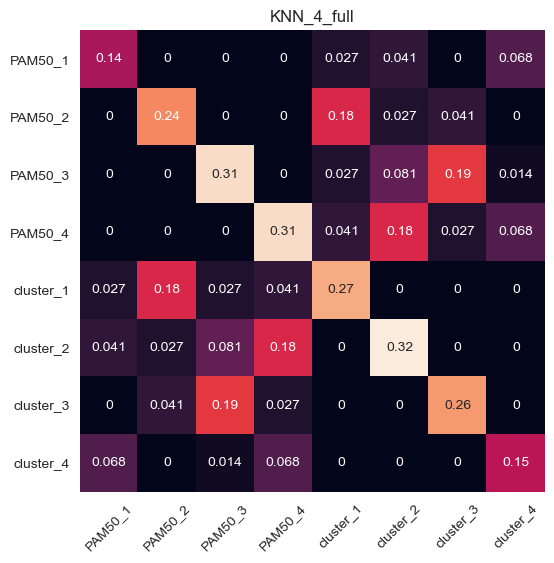

In [21]:
matrix = confusion_matrix(Y, pred, name='KNN_4_full')

In [34]:
correctness = 0
mistakes = 0

cm = matrix[4:, :4]
highest_by_row = np.max(cm, axis=1)

correctness += highest_by_row[np.argmax(highest_by_row)]
highest_by_row.drop(np.argmax(highest_by_row))

In [41]:
cm

array([[0.02702703, 0.17567568, 0.02702703, 0.04054054],
       [0.04054054, 0.02702703, 0.08108108, 0.17567568],
       [0.        , 0.04054054, 0.18918919, 0.02702703],
       [0.06756757, 0.        , 0.01351351, 0.06756757]])

In [45]:
# correctness += highest_by_row[np.argmax(highest_by_row)]
# highest_by_row.

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

## 5. Model improvement

### 5.1 Feature selection

In [22]:
# for i in range(20):
#     random.seed(i)
#     all_features = X_scaled.columns.values.tolist()
#     num_features_rand = random.sample(range(X_scaled.shape[1]), 1)
#     features_selected = random.sample(all_features, num_features_rand[0])
#     print(num_features_rand[0])
#     X_reduced = X_scaled[features_selected]
#
#     k_means = KMeans(n_clusters=4, algorithm='full').fit(X_reduced)
#     pred_ = k_means.labels_
#     matrix = eval_matrix(Y, pred_, name='KNN_4_full_' + str(num_features_rand[0]) + '_features')
#
#     # print("# Feature Selected: ", num_features_rand[0])
#     print("Feature Selected: ", features_selected)
#     # print(matrix)

### 5.2 Model selection